In [1]:
""" 
The diff_dir folder contains points classified by 2 different methods, with consensus (1), predicted building 
by G (2) or by E (3) only. we cross it with probabilities and look at the confusion, using the AI model as a referee.
"""

import laspy
import numpy as np
import torch; torch.set_grad_enabled(False);
from torch_geometric.nn.pool import knn
from sklearn.metrics import confusion_matrix as cm
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
l = "791000_6270000.las 864000_6649000.las 871000_6649000.las 877000_6647000.las 923000_6308000.las 791000_6271000.las 870000_6619000.las 875000_6616000.las 887000_6613000.las 923000_6323000.las 861000_6649000.las 871000_6619000.las 875000_6619000.las 888000_6614000.las 924000_6309000.las"
l = l.split(" ")
# MISSING IN DIFFERENTIAL
l = [a for a in l if a != "861000_6649000.las"]
print(l)
diff_dir = "/var/data/cgaydon/data/projet-LHD/IA/Multiclass-Segmentation/data/building_macro_differential_20220204_building_val/test_set/"
preds_dir = "/var/data/cgaydon/data/projet-LHD/IA/Multiclass-Segmentation/versions/20220204_building_val_models/V0.0/test_preds/"

['791000_6270000.las', '864000_6649000.las', '871000_6649000.las', '877000_6647000.las', '923000_6308000.las', '791000_6271000.las', '870000_6619000.las', '875000_6616000.las', '887000_6613000.las', '923000_6323000.las', '871000_6619000.las', '875000_6619000.las', '888000_6614000.las', '924000_6309000.las']


In [3]:
CM = np.zeros(shape=(3,3))
CM_nonorm = np.zeros(shape=(3,3))

for f in tqdm(l):
    diff = laspy.read(diff_dir+f)
    diff_pos = np.asarray([diff.x, diff.y, diff.z], dtype=np.float32).transpose()
    clf = diff.classification

    las = laspy.read(preds_dir+"predict_"+f)
    las_pos = np.asarray([las.x, las.y, las.z], dtype=np.float32).transpose()

    # Start with simple confusion !
    assign_idx = knn(
        torch.Tensor(las_pos),
        torch.Tensor(diff_pos),
        k=1,
        num_workers=1,
    )[1]
    probas = las.building[assign_idx]
    CM_nonorm += cm(probas >= 0.5, clf -1, labels = [0,1,2]).round(3)
    CM += cm(probas >= 0.5, clf -1, labels = [0,1,2], normalize="pred").round(3)
CM = CM/len(l)

100%|██████████| 14/14 [04:18<00:00, 18.50s/it]


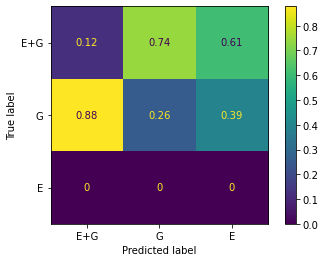

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay
cmd = ConfusionMatrixDisplay(CM, display_labels=["E+G","G","E"])
cmd.plot()

In [9]:
CM

array([[0.12192857, 0.743     , 0.60885714],
       [0.87807143, 0.257     , 0.39114286],
       [0.        , 0.        , 0.        ]])

In [10]:
CM_nonorm

array([[ 1206482.,   981725.,   209349.],
       [18838967.,   448585.,   117770.],
       [       0.,        0.,        0.]])